# 1. Loading dataset

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import statsmodels.formula.api as smf


In [38]:
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df_original = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

df_original.head(10)


#df_original = pd.read_csv('Desktop/Thinkful/weatherHistory.csv')


,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.289,5.944,0.830,14.104,269.000,15.826,0.000,1016.410,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.756,6.978,0.830,11.045,259.000,15.826,0.000,1016.510,Partly cloudy throughout the day.
5,2006-04-01 03:00:00+00:00,Partly Cloudy,rain,9.222,7.111,0.850,13.959,258.000,14.957,0.000,1016.660,Partly cloudy throughout the day.
6,2006-04-01 04:00:00+00:00,Partly Cloudy,rain,7.733,5.522,0.950,12.365,259.000,9.982,0.000,1016.720,Partly cloudy throughout the day.
7,2006-04-01 05:00:00+00:00,Partly Cloudy,rain,8.772,6.528,0.890,14.152,260.000,9.982,0.000,1016.840,Partly cloudy throughout the day.
8,2006-04-01 06:00:00+00:00,Partly Cloudy,rain,10.822,10.822,0.820,11.318,259.000,9.982,0.000,1017.370,Partly cloudy throughout the day.
9,2006-04-01 07:00:00+00:00,Partly Cloudy,rain,13.772,13.772,0.720,12.526,279.000,9.982,0.000,1017.220,Partly cloudy throughout the day.


# 2. Preliminary data exploration

In [39]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


In [40]:
df_original.describe()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000
mean,11.933,10.855,0.735,10.811,187.509,10.347,0.000,1003.236
std,9.552,10.697,0.195,6.914,107.383,4.192,0.000,116.970
min,-21.822,-27.717,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.689,2.311,0.600,5.828,116.000,8.340,0.000,1011.900
50%,12.000,12.000,0.780,9.966,180.000,10.046,0.000,1016.450
75%,18.839,18.839,0.890,14.136,290.000,14.812,0.000,1021.090
max,39.906,39.344,1.000,63.853,359.000,16.100,0.000,1046.380


In [41]:
df_original.describe(include=['object'])

,summary,preciptype,dailysummary
count,96453,96453,96453
unique,27,3,214
top,Partly Cloudy,rain,Mostly cloudy throughout the day.
freq,31733,85224,20085


# 3. Missing Values

In [42]:
df_original.isnull().sum()*100/df_original.isnull().count()

date                  0.000
summary               0.000
preciptype            0.000
temperature           0.000
apparenttemperature   0.000
humidity              0.000
windspeed             0.000
windbearing           0.000
visibility            0.000
loudcover             0.000
pressure              0.000
dailysummary          0.000
dtype: float64

We have missing values only in 'Precip Type' but we will not use it in our analysis.

# 4. EDA

Target variable is *temperature*. 
Explanatory variables: humidity, windspeed, windbearing, and pressure

In [43]:
import seaborn as sns

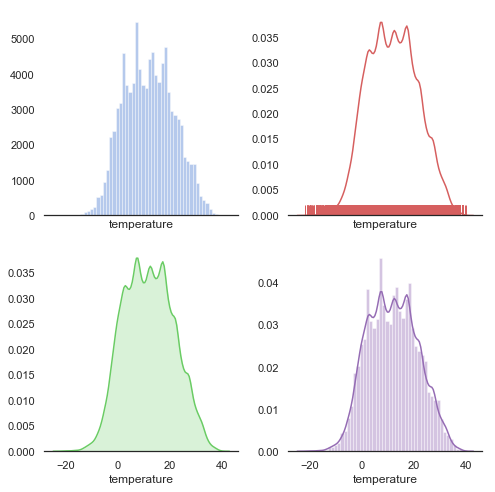

In [44]:
sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
sns.despine(left=True)

# Generate dataset
d = df_original['temperature']

# Plot a simple histogram with binsize determined automatically
sns.distplot(d, kde=False, color="b", ax=axes[0, 0])

# Plot a kernel density estimate and rug plot
sns.distplot(d, hist=False, rug=True, color="r", ax=axes[0, 1])

# Plot a filled kernel density estimate
sns.distplot(d, hist=False, color="g", kde_kws={"shade": True}, ax=axes[1, 0])

# Plot a historgram and kernel density estimate
sns.distplot(d, color="m", ax=axes[1, 1])

plt.tight_layout()

Text(0.5, 1.0, 'The distribution of temperature')

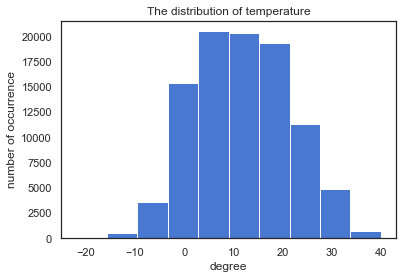

In [45]:
plt.hist(df_original['temperature'])

plt.xlabel("degree")
plt.ylabel("number of occurrence")
plt.title("The distribution of temperature")

In [46]:
df_original['temperature'].describe()

count   96453.000
mean       11.933
std         9.552
min       -21.822
25%         4.689
50%        12.000
75%        18.839
max        39.906
Name: temperature, dtype: float64

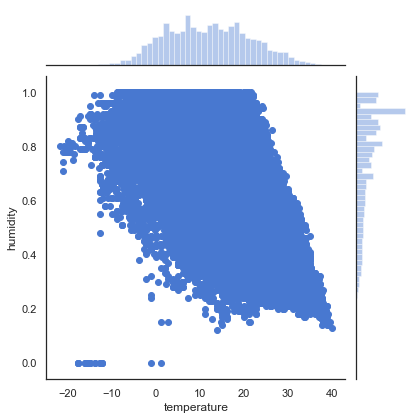

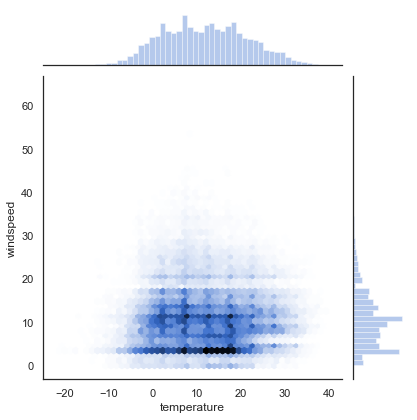

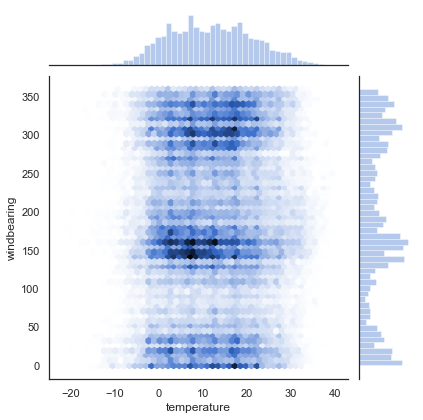

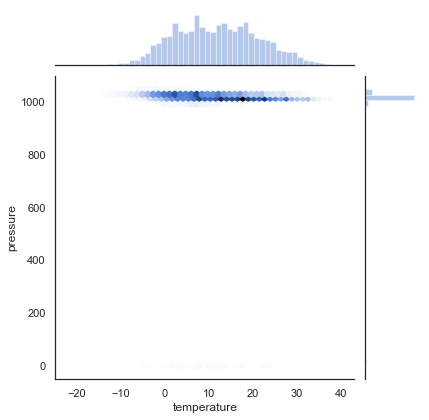

In [47]:
sns.jointplot(x=d, y="humidity", data=df_original);
with sns.axes_style("white"):
    sns.jointplot(x=d, y="windspeed", data = df_original, kind="hex");
with sns.axes_style("white"):
    sns.jointplot(x=d, y="windbearing", data = df_original, kind="hex");
with sns.axes_style("white"):
    sns.jointplot(x=d, y="pressure", data = df_original, kind="hex");
    


In [48]:
df = df_original.copy()


In [49]:
df = df[['temperature', 'humidity', 'windspeed', 'windbearing', 'pressure']]

In [50]:
df.head()

,temperature,humidity,windspeed,windbearing,pressure
0,9.472,0.890,14.120,251.000,1015.130
1,9.356,0.860,14.265,259.000,1015.630
2,9.378,0.890,3.928,204.000,1015.940
3,8.289,0.830,14.104,269.000,1016.410
4,8.756,0.830,11.045,259.000,1016.510


In [51]:
df.corr()

,temperature,humidity,windspeed,windbearing,pressure
temperature,1.000,-0.632,0.009,0.030,-0.005
humidity,-0.632,1.000,-0.225,0.001,0.005
windspeed,0.009,-0.225,1.000,0.104,-0.049
windbearing,0.030,0.001,0.104,1.000,-0.012
pressure,-0.005,0.005,-0.049,-0.012,1.000


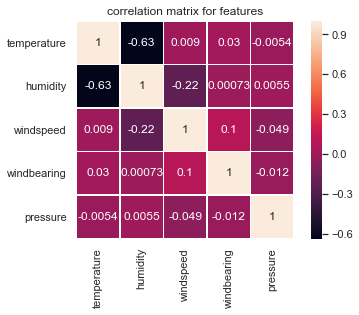

In [52]:
sns.heatmap(df.corr(), square=True, annot=True, linewidths=.5)
plt.title("correlation matrix for features")
plt.show()

# 5. Building a regression model (estimation the model using OLS)

In [53]:
# Y is the target variable
Y = df['temperature']
# X is the feature set which includes
# is_male and is_smoker variables
X = df[['humidity', 'windspeed', 'windbearing', 'pressure']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.92643818528537


LinearRegression()'s fit() method runs the OLS algorithm by default. Since we get the parameters using OLS, we can write our estimated model:

Temperature = 37.93 - 32.5*Humidity - 0.21 * Wind Speed + 0.004 * Wind Bearing - 0.00069 * Pressure

Now, we run the same model, this time using statsmodels. If you didn't install it already, you can run pip install statsmodels from the command line.



In [54]:
import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 1.750e+04
Date:                Wed, 14 Aug 2019   Prob (F-statistic):               0.00
Time:                        09:39:11   Log-Likelihood:            -3.2821e+05
No. Observations:               96453   AIC:                         6.564e+05
Df Residuals:                   96448   BIC:                         6.565e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.9264      0.233    162.709      0.000      37.470      38.383
humidity      -32.4962      0.123   -264.288      0.000     -32.737     -32.255
windspeed      -0.2014      0.003    -57.557      0.000      -0.208      -0.195
windbearing     0.0040      0.000     18.463      0.000       0.004       0.004
pressure       -0.0007      0.000     -3.452      0.001      -0.001      -0.000
==============================================================================
Omnibus:                     3375.432   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3793.297
Skew:                          -0.455   Prob(JB):                         0.00
Kurtosis:                       3.339   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 6. Meeting the assumptions of linear regression

Now we are going to check if our model meets the Gauss-Markov Conditions.

### Assumption one: linearity of the model in its coefficients

Temperature = 37.93 - 32.5*Humidity - 0.21 * Wind Speed + 0.004 * Wind Bearing - 0.00069 * Pressure

Linearity assumption- in principle, the linearity assumption is not related to estimation but to how we specify our model. So as long as we use models that take into account this linearity assumption then we shouldn't worry about this assumption at all. Hence, as far as we are using sklearn's linear regression, this assumption is met already. 

### Assumption two: the error term should be zero on average

In [56]:
#lin_reg.resid.mean()
Y = df['temperature']
# X is the feature set which includes
# is_male and is_smoker variables
X = df[['humidity', 'windspeed', 'windbearing', 'pressure']]
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)
predictions = lrm.predict(X)
errors = Y - predictions


print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -4.653036515526058e-16


### Assumption three: homoscedasticity

To investigate if the residuals are homoscedastic, we can look at a plot of residuals (or standardized residuals) vs. predicted (fitted) values. What should alarm us is the case when the residuals grow either as a function of predicted value or time (in case of time series).

We can also use two statistical tests: Breusch-Pagan and Goldfeld-Quandt. In both of them, the null hypothesis assumes homoscedasticity and a p-value below a certain level (like 0.05) indicates we should reject the null in favor of heteroscedasticity.

In the snippets below I plot residuals (and standardized ones) vs. fitted values and carry out the two mentioned tests. To identify homoscedasticity in the plots, the placement of the points should be random and no pattern (increase/decrease in values of residuals) should be visible — the red line in the R plots should be flat. We can see that this is not the case for our dataset.


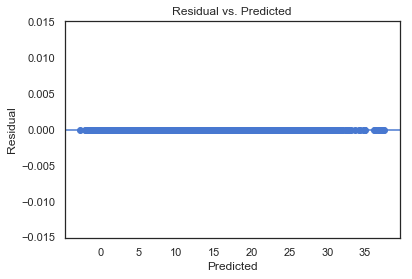

In [57]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()



Here, we demonstrate two of them: Bartlett and Levene tests. The null hypothesis for both tests is that the errors are homoscedastic. Both tests can be imported from scipy's stats module.

In [58]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 6.36899e+06 and p value is 0
Levene test statistic value is 142158 and p value is 0


The p-values of both tests are lower than 0.05. So, the test results reject the null hypothesis which means our errors are heteroscedastic.

#### Potential solutions:
- log transformation of the dependent variable
- in case of time series, deflating a series if it concerns monetary value
- using ARCH (auto-regressive conditional heteroscedasticity) models to model the error variance. An example might be stock market, where data can exhibit periods of increased or decreased volatility over time (volatility clustering, see this article for more information)

### Assumption four: low multicollinearity

If there is correlation of 1 or -1 between a variable and another or several variables, this is called perfect multicollinearity. 

Text(0.5, 1.0, 'Correlation matrix')

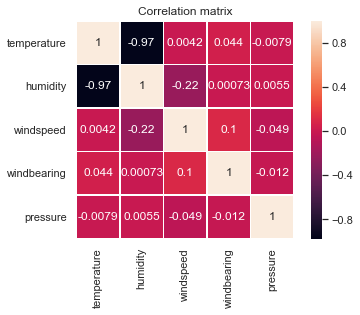

In [59]:
sns.heatmap(df.corr(), annot = True, linewidths = .3, square = True)
plt.title('Correlation matrix')

### Assumption five: error terms should be uncorrelated with one another

In other words, the error term for one observation shouldn't predict the error term for another. To identify whether the error terms are correlated with each other or not, we can graph them. In the graph, we need to observe randomness.

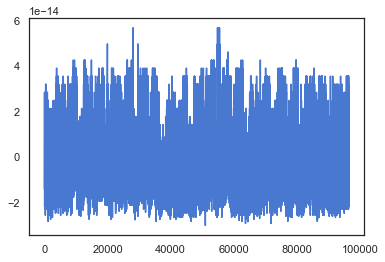

In [60]:
plt.plot(errors)

Another way to look at correlations between errors is to use the autocorrelation function. This function computes the correlation of a variable with itself. In our case, the order of the errors are the orders of the observations.

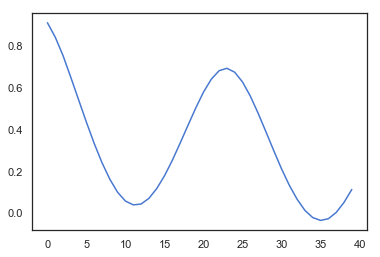

In [61]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

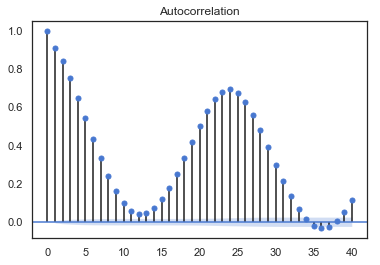

In [62]:
import statsmodels.tsa.api as smt

acf = smt.graphics.plot_acf(errors, lags=40 , alpha=0.05)
acf.show()

### Assumption six: features shouldn't be correlated with the errors

To investigate this assumption I check the Pearson correlation coefficient between each feature and the residuals. Then report the p-value for testing the lack of correlation between the two considered series.

In [63]:
from scipy.stats.stats import pearsonr

for column in X.columns:
    corr_test = pearsonr(X[column], errors)
    print(f'Variable: {column} --- correlation: {corr_test[0]:.4f}, p-value: {corr_test[1]:.4f}')


Variable: humidity --- correlation: -0.9811, p-value: 0.0000
Variable: windspeed --- correlation: 0.2139, p-value: 0.0000
Variable: windbearing --- correlation: -0.0365, p-value: 0.0000
Variable: pressure --- correlation: 0.0219, p-value: 0.0000


p-value = 0 so we can reject the null hypothesis (lack of correlation) for any pair.

### Assumption 7: normality of the errors

Text(0.5, 1.0, 'Histogram of the errors')

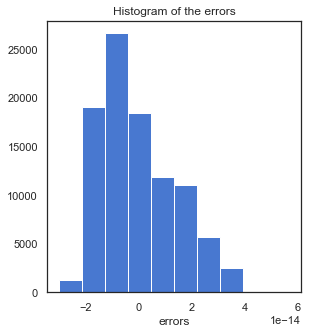

In [64]:
plt.figure(figsize = (10,5))

plt.subplot(1, 2, 1)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")



Jarque-Bera test statistics is 7723.247236701296 and p value is 0.0
Normality test statistics is 6998.632564185899 and p value is 0.0


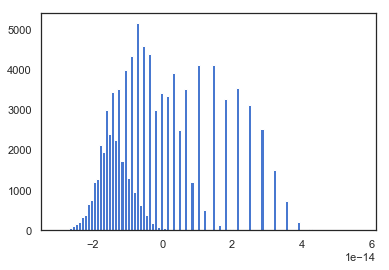

In [65]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

# Test whether distribution is Normal
# Null Hypo: Distribution is normal
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)
print(f"Jarque-Bera test statistics is {jb_stats[0]} and p value is {jb_stats[1]}")
print(f"Normality test statistics is {norm_stats[0]} and p value is {norm_stats[1]}")

# Plot distribution
plt.hist(errors, bins=100)
plt.show()

The p-values of both tests indicate that our errors are not normally distributed. Visually it looks terrible.


# Interpreting estimated coefficients

In [ ]:
# Y is the target variable
Y = weather_df['apparenttemperature'] - weather_df['temperature']
# X is the feature set
X = weather_df[['humidity','windspeed']]
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()
results.summary()


The estimated coefficients statistically significant (p-values = 0)

target = 2.4381 - 3.0292 humidity - 0.1193 windspeed

According to the estimated model, 1 point increase in the humidity results in 3.0292 points decrease in the target. 1 point increase in the windspeed is associated with 0.1193 point decrease in our target.

In [ ]:
Y = weather_df['target']
weather_df['Hum_Wind'] = weather_df['humidity'] * weather_df['windspeed']
X = weather_df[['humidity', 'windspeed', 'Hum_Wind']]
X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()

# We print the summary results
print(results.summary())

1) coefficients are still statistically significant (since p-value < 0.05)

2) after including the intereaction term, signs of humidity and windspeed changed from negative to the positive

3) According to the model, 1 point increase in the humidity and windspeed results in 0.18 and 0.09 point increases in the target respectively.

4) According to the model, the coefficient of the interaction term is -0.30. We can interpret it as follows. Given a windspeed level, 1 point increase in humidity results in 0.18 - 0.30 X windspeed point increase in the target. This means that the increase in the target is lower for high values of windspeed than for low values of windspeed. So, the windspeed mitigates the effect of humidity increase on the target. Similarly for a given humidity level, 1 point increase in the windspeed results in 0.09 - 0.30 X humidity point increase in the target. So, the humidity also mitigates the effect of windspeed on the target.

## Model 3

In [ ]:
Y = weather_df['target']
weather_df['Hum_Wind'] = weather_df['humidity'] * weather_df['windspeed']
X = weather_df[['humidity', 'windspeed', 'visibility']]
X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()

# We print the summary results
print(results.summary())

# Evaluating performance

#### Model 1
- R-squared:	0.304
- Adj. R-squared:	0.288
- F-statistic:	1.949e+04
- Prob (F-statistic):	0.00
- Log-Likelihood:	-1.7046e+05
- AIC:	3.409e+05
- BIC:	3.409e+05

R-squared is pretty low. That's mean 72% data aren't explained by our model. 

#### Model 2
- R-squared:                       0.341
- Adj. R-squared:                  0.341
- F-statistic:                 1.666e+04
- Prob (F-statistic):               0.00
- AIC:                         3.334e+05
- BIC:                         3.334e+05

#### Model 3
- R-squared:                       0.341
- Adj. R-squared:                  0.303
- F-statistic:                 1.401e+04
- Prob (F-statistic):               0.00
- AIC:                         3.388e+05
- BIC:                         3.388e+05

In this case  R-squared is higher and  AIC and BIC are lower - that makes the second model preforable. But  R-squared is still very low. 
Model 3 is bette than Model 1 because it has higher R-squared. 